In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt
import sys

from pathlib import Path

import pandas as pd

from river import utils, compose
from river.proba import Gaussian

sys.path.insert(1, str(Path().resolve().parent))
from functions.anomaly import GaussianScorer, ConditionalGaussianScorer
from functions.proba import MultivariateGaussian
from functions.evaluate import progressive_val_predict

from models.bess_model import BESS

from publications.ilustrate.pc2023.plot_matplotlib import *

In [3]:
df = pd.read_csv("data/data_BESS_norm.csv", index_col=0)
df.index = pd.to_datetime(df.index, utc=True)

In [4]:
# CONSTANTS
days = 4
WINDOW = dt.timedelta(days=days)
minutes = int(WINDOW.total_seconds() / 60)
GRACE_PERIOD = int(minutes / 4)
THRESHOLD = 0.9995

# It's possible to blacklist some features in the loop
blacklist = [
    "String Power",
    "Active Power Setpoint",
    "Ambient Temperature",
    "SOC",
    "Battery part Fan Vb1 Feedback",
    "HVAC Battery part Circulation Fan V1",
    "HVAC Battery part cooling",
    "HVAC Battery part heating",
    "Max. Cell Temperatue",
    "Min. Cell Temperature",
    # "Avg. Cell Temperature",
    "Power Setpoint Deviation",
]

# Using model to retrieve the features is simple
model = BESS()
# Here we use a compose pipeline to discard some features
model = compose.Discard(*blacklist)
model |= ConditionalGaussianScorer(
    # utils.TimeRolling(MultivariateGaussian(), period=WINDOW),
    utils.Rolling(MultivariateGaussian(), window_size=minutes),
    grace_period=GRACE_PERIOD,
    t_a=60 * 3,
    threshold=THRESHOLD,
)

sampling_model = GaussianScorer(
    Gaussian()._from_state(minutes, 60, 60**2, 1),
    protect_anomaly_detector=False,
)

system_anomaly, meta = progressive_val_predict(
    model=model,
    dataset=df,
    compute_limits=True,
    detect_signal=True,
    detect_change=True,
    sampling_model=sampling_model,
)

df_out = pd.DataFrame(
    {"System Anomaly": system_anomaly, **meta}, index=df.index
)

Avg. latency per sample: 0.8057220140304376ms


In [5]:
events_count = sum(pd.Series(system_anomaly).diff().dropna() == 1)
text = (
    f"Sliding window: {WINDOW}\n"
    f"Proportion of anomalous samples: "
    f"{sum(system_anomaly)/len(system_anomaly)*100:.02f}%\n"
    f"Anomaly every: "
    f"{len(system_anomaly)/sum(system_anomaly):.00f} samples\n"
    f"Total number of anomalous events: "
    f"{events_count}\n"
    f"Anomalous event every: "
    f"{len(system_anomaly)/events_count:.00f} samples\n"
    f"Total number of change points: "
    f"{sum(df_out['Changepoint'].diff().dropna() == 1)}\n"
    f"Total number of sampling anomalies: "
    f"{sum(df_out['Sampling Anomaly'].diff().dropna() == 1)}"
)

print(text)

Sliding window: 4 days, 0:00:00
Proportion of anomalous samples: 6.22%
Anomaly every: 16 samples
Total number of anomalous events: 14
Anomalous event every: 893 samples
Total number of change points: 2
Total number of sampling anomalies: 3


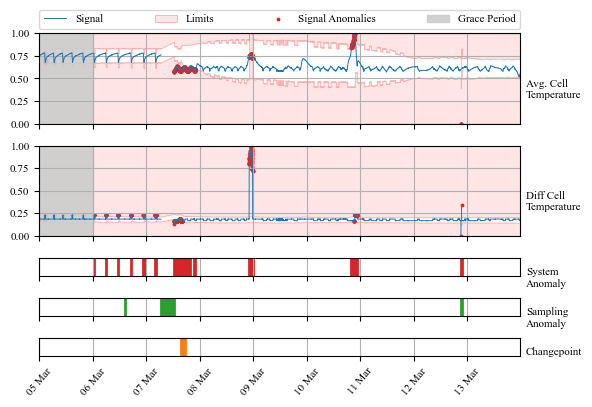

In [6]:
plot_limits_grid_(
    df,
    df_out["Changepoint"],
    df_out["Sampling Anomaly"],
    df_out["System Anomaly"],
    ser_high=df_out["Limit High"].iloc[1:],
    ser_low=df_out["Limit Low"].iloc[1:],
    signal_anomaly=df_out["Signal Anomaly"],
    file_name="TERRA",
    save=True,
    **{"resample": "1t", "grace_period": GRACE_PERIOD},
)